<a href="https://colab.research.google.com/github/lespinozahuiman/FutureSales/blob/main/FutureSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports de librerías
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split

In [4]:
### Cargar del dataset
url = 'https://raw.githubusercontent.com/lespinozahuiman/Datasets/main/DataSet_TF_v5.csv'

data = pd.read_csv(url)
#data['TotalSales'] = data['PricePerUnit'] * data['UnitsSold']
data.head()

,Retailer,RetailerID,InvoiceDate,Region,State,City,Product,PricePerUnit,UnitsSold,TotalSales,OperatingProfit,SalesMethod
0,Walmart,1128299,17-06-2021,Southeast,Florida,Orlando,Women's Apparel,103.0,218.0,2245.0,1257.0,Online
1,West Gear,1128299,16-07-2021,South,Louisiana,New Orleans,Women's Apparel,103.0,163.0,1679.0,806.0,Online
2,Sports Direct,1197831,25-08-2021,South,Alabama,Birmingham,Men's Street Footwear,10.0,700.0,7000.0,3150.0,Outlet
3,Sports Direct,1197831,27-08-2021,South,Alabama,Birmingham,Women's Street Footwear,15.0,575.0,8625.0,3881.0,Outlet
4,Sports Direct,1197831,21-08-2021,South,Alabama,Birmingham,Women's Street Footwear,15.0,475.0,7125.0,3206.0,Outlet


In [5]:
df_s = data.copy()

In [9]:
# Metodo para agrupar las ventas en funcion al mes o año
# Retorna un DataFrame
def monthOrYears_sales(data, time=['monthly', 'year']):
    data = data.copy()

    if time == "monthly":
        data.InvoiceDate = data.InvoiceDate.apply(lambda x: str(x)[:-3])
    else:
        data.InvoiceDate = data.InvoiceDate.apply(lambda x: str(x)[:4])

    data = data.groupby('InvoiceDate')['TotalSales'].sum().reset_index()
    data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

    return data

In [10]:
m_df = monthOrYears_sales(df_s, "monthly")
m_df.head(10)

<ipython-input-9-da92a89af28d>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.InvoiceDate = pd.to_datetime(data.InvoiceDate)


,InvoiceDate,TotalSales
0,2002-01-01,150004.0
1,2002-01-02,142002.0
2,2002-01-03,166262.0
3,2002-01-04,82967.0
4,2002-01-05,251084.0
5,2002-01-06,334206.0
6,2002-01-07,225750.0
7,2002-01-08,142569.0
8,2002-01-09,341885.0
9,2002-01-10,387630.0


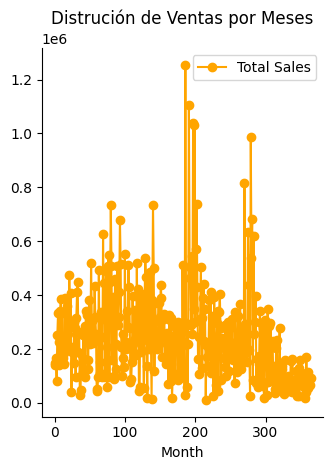

In [13]:
layout = (1, 2)

law = plt.subplot2grid(layout, (0, 1))

months = m_df['TotalSales'].plot(marker='o', color='orange', label='Total Sales', ax=law)

months.set(xlabel='Month', title='Distrución de Ventas por Meses')

sns.despine()
plt.tight_layout()
months.legend()

In [14]:
def sales_per_store(data):
    sales_by_store = data.groupby('Retailer')['TotalSales'].sum().reset_index()

    #fig, ax = plt.subplots(figsize=(8, 6))
    #sns.barplot(sales_by_store.Retailer, sales_by_store.TotalSales, color='red')

    #ax.set(xlabel="Store", ylabel="Total de Ventas", title="Total de Ventas por Tienda")

    return sales_by_store

In [15]:
sales_per_store(df_s)

,Retailer,TotalSales
0,Amazon,7769912.0
1,Foot Locker,21989528.0
2,Kohl's,10211506.0
3,Sports Direct,18188531.0
4,Walmart,7455850.0
5,West Gear,24204740.0


In [16]:
def get_diff(data):
    data['sales_diff'] = data.TotalSales.diff()
    data = data.dropna()

    return data

In [17]:
stationary_df = get_diff(m_df)

In [18]:
# ARIMA
def build_arima_data(data):
    da_data = data.set_index('InvoiceDate').drop('TotalSales', axis=1)
    da_data.dropna(axis=0)

    return da_data

In [19]:
datatime_df = build_arima_data(stationary_df)
datatime_df

,sales_diff
InvoiceDate,
2002-01-02,-8002.0
2002-01-03,24260.0
2002-01-04,-83295.0
2002-01-05,168117.0
2002-01-06,83122.0
...,...
2002-05-31,-14634.0
2002-07-31,62188.0
2002-08-31,-23110.0


In [ ]:
# Construyendo modelo supervisado
def build_supervised(data):
    supervised_df = data.copy()

    for i in range(1,4):
        col_name = 'month_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    supervised_df = supervised_df.dropna().reset_index(drop=True)

    return supervised_df

In [ ]:
model_df = build_supervised(stationary_df)
model_df

,InvoiceDate,TotalSales,sales_diff,month_1,month_2,month_3
0,2002-01-05,251084.0,168117.0,-83295.0,24260.0,-8002.0
1,2002-01-06,334206.0,83122.0,168117.0,-83295.0,24260.0
2,2002-01-07,225750.0,-108456.0,83122.0,168117.0,-83295.0
3,2002-01-08,142569.0,-83181.0,-108456.0,83122.0,168117.0
4,2002-01-09,341885.0,199316.0,-83181.0,-108456.0,83122.0
...,...,...,...,...,...,...
356,2002-05-31,53777.0,-14634.0,-100637.0,127414.0,22315.0
357,2002-07-31,115965.0,62188.0,-14634.0,-100637.0,127414.0
358,2002-08-31,92855.0,-23110.0,62188.0,-14634.0,-100637.0
359,2002-10-31,65804.0,-27051.0,-23110.0,62188.0,-14634.0


In [ ]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  361 non-null    datetime64[ns]
 1   TotalSales   361 non-null    float64       
 2   sales_diff   361 non-null    float64       
 3   month_1      361 non-null    float64       
 4   month_2      361 non-null    float64       
 5   month_3      361 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 17.1 KB


In [ ]:
def train_test_split(data):
    data = data.drop(['TotalSales', 'InvoiceDate'], axis=1)

    train, test = data[:-12].values, data[-12:].values

    return train, test

train, test = train_test_split(model_df)
print(f"Train : {train.shape}")
print(f"Test : {test.shape}")

Train : (349, 4)
Test : (12, 4)


In [ ]:
def scale_data(train_set, test_set):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()

    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"X Train: {X_train.shape}")
print(f"y Train: {y_train.shape}")
print(f"X Test: {X_test.shape}")
print(f"y Test: {y_test.shape}")

X Train: (349, 3)
y Train: (349,)
X Test: (12, 3)
y Test: (12,)


In [ ]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])


    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], x_test[index]], axis=1))


    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted

In [ ]:
def prediction_df(unscale_predictions, origin_df):
    result_list = []
    sales_dates = list(origin_df[-13:].InvoiceDate)
    act_sales = list(origin_df[-13:].TotalSales)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['InvoiceDate'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

In [ ]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    rmse = np.sqrt(mean_squared_error(origin_df.TotalSales[-12:], unscale_df.pred_value[-12:]))

    mae = mean_absolute_error(origin_df.TotalSales[-12:], unscale_df.pred_value[-12:])

    r2 = r2_score(origin_df.TotalSales[-12:], unscale_df.pred_value[-12:])

    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

In [ ]:
def regressive_model(train_data, test_data, model, model_name):
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)

    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) # y_pred=predictions

    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object) # unscaled_predictions
    unscaled_df = prediction_df(unscaled, origin_df)

    get_scores(unscaled_df, origin_df, model_name)

In [ ]:
# Modelo Regresión Lineal
regressive_model(train, test, LinearRegression(), 'LinearRegression')

RMSE: 45599.947382096834
MAE: 34564.583333333336
R2 Score: -0.34963739959470574


In [ ]:
# Modelo Random Forest
regressive_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 'RandomForest')

RMSE: 99872.64747709122
MAE: 76667.08333333333
R2 Score: -5.4741319480198865


In [ ]:
# Modelo xGBoost
regressive_model(train, test, XGBRegressor(n_estimators=100,max_depth=3, learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')

RMSE: 100381.08331586518
MAE: 80734.0
R2 Score: -5.540217297780758
